# Baseline 2-Staged Least Squares Instrumental Variables Regression using Cornelia's Randomized Medical Data

In [84]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [85]:
# download this extra package from here: https://github.com/bashtage/linearmodels
#!pip install linearmodels
# from linearmodels.iv import IV2SLS as IV2SLS_v2

In [86]:
# local or gdrive
path_source = 'local'

if path_source == 'gdrive':
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/Data'
  #env_path = '/content/gdrive/MyDrive/.env'
  
elif path_source == 'local':
  data_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  #env_path = '/content/gdrive/MyDrive/.env'

elif path_source == 'work':
  data_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'

# Read in data

In [87]:
# read in our modeling data
df = pd.read_csv(os.path.join(data_path, 'modeling_data/modeling_data_2022-10-16.csv'))

# read in cornelia's healthcare data
df1 = pd.read_csv(os.path.join(data_path, 'medical/hematopoietic_cancers.csv')).iloc[:,1:]
df2 = pd.read_csv(os.path.join(data_path, 'medical/pediatric_vasculitis.csv')).iloc[:,1:]
df3 = pd.read_csv(os.path.join(data_path, 'medical/type_1_diabetes.csv')).iloc[:,1:]

# Data clean

Clean med data

In [88]:
# get all distinct patzip_year_month
all_pats = df1['patzip_year_month'].to_list() + df2['patzip_year_month'].to_list() + df3['patzip_year_month'].to_list()
all_pats = list(set(all_pats))
df_med = pd.DataFrame({'patzip_year_month': all_pats})

# rename columns more intuitively
df1 = df1.rename(columns={'number_of_visits': 'number_of_visits_hem_cancers'})
df2 = df2.rename(columns={'number_of_visits': 'number_of_visits_vasc'})
df3 = df3.rename(columns={'number_of_visits': 'number_of_visits_diab'})

# now join all the diagnoses on this dataset
df_med = df_med\
  .merge(df1, on='patzip_year_month', how='left')\
  .merge(df2, on='patzip_year_month', how='left')\
  .merge(df3, on='patzip_year_month', how='left')

df_med.head(3)

,patzip_year_month,hematopoietic_cancers,number_of_visits_hem_cancers,pediatric_vasculitis,number_of_visits_vasc,type_1_diabetes,number_of_visits_diab
0,92882-2016-7,1.0,17.0,NaN,NaN,1.0,17.0
1,91732-2013-7,NaN,NaN,1.0,19.0,NaN,NaN
2,93291-2013-6,NaN,NaN,1.0,17.0,NaN,NaN


Join med data

In [89]:
df['year_month'] = df['year_month'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df['zip_year_month'] = df['school_zip'].astype(str) + '-' +\
  df['year_month'].dt.year.astype(str) + '-' +\
  df['year_month'].dt.month.astype(str)

df = pd.merge(df, df_med, left_on='zip_year_month', right_on='patzip_year_month', how='left')

# for missing med data, assume there were 0 cases:
med_vars = ['hematopoietic_cancers', 'number_of_visits_hem_cancers', 'pediatric_vasculitis', 
  'number_of_visits_vasc', 'type_1_diabetes', 'number_of_visits_diab']
for var in med_vars:
  df[var] = df[var].fillna(0)

# fixing month datatype
df['month'] = df['month'].astype(str)

print(df.shape[0])

311163


Var transformations

In [90]:
# Create response variables, which is visits / population
df['y_hematopoietic'] = df['number_of_visits_hem_cancers'] / df['total_pop_under19']
df['y_vasculitis'] = df['number_of_visits_vasc'] / df['total_pop_under19']
df['y_diabetes'] = df['number_of_visits_diab'] / df['total_pop_under19']

# Make treatment var normally distributed by taking log(1+x)
df['pm25_log'] = np.log1p(df['pm25'])

Define all variables we'll be using

In [91]:
[i for i in df.columns if re.search('pm25_r.', i)]

['pm25_r6', 'pm25_r9', 'pm25_r12', 'pm25_r24']

In [92]:
# X vars
#x_wind = ['school_wspd', 'ps_wspd_merge', 'avg_wind_speed']
x_wind = ['school_wspd', 'ps_wspd_merge']
x_elevation = ['school_elevation_m', 'ps_elevation_m']
x_population = [i for i in df.columns if (re.search('population_', i) and re.search('male', i))] # + ['pop_under19_male', 'pop_under19_female']
x_socioecon = ['ca_agi_per_returns', 'tax_liability_per_capita']
x_temp = ['school_temperature', 'ps_temperature']
x_window = ['pm25_last_month', 'pm25_r6', 'pm25_r9', 'pm25_r12', 'pm25_r24', 'pm25_slope6', 'pm25_slope9', 'pm25_slope12', 'pm25_slope24', 'pm25_lag_12mo']
x_other = ['nearby_point_source_count', 'school_count', 'point_source_pm25_tpy']
x_time = ['year'] + [i for i in df.columns if (re.search('month_', i) and i not in 'month_01')]
x_region = [i for i in df.columns if (re.search('school_region_name_', i) and i not in 'school_region_name_los_angeles_county')]
# vars I dont think we can use:
#point_source_pm25_tpy
x_all = x_wind + x_elevation + x_population + x_socioecon + x_temp + x_window + x_other + x_time + x_region
x_vars_for_tree_model = x_wind + x_elevation + x_population + x_socioecon + x_temp + x_window + x_other + ['year', 'month', 'school_region_name']

other_vars_to_keep = ['month_01', 'school_region_name_los_angeles_county', 'month', 'school_region_name']

instrument = ['avg_wind_alignment_cosine']

y_pm25_log = ['pm25_log']
y_pm25 = ['pm25']

y_hema = ['y_hematopoietic']
y_vasc = ['y_vasculitis']
y_diab = ['y_diabetes']

all_vars_to_keep = list(set(x_all + other_vars_to_keep + instrument + y_pm25_log + y_pm25 + y_hema + y_vasc + y_diab))

Select only necessary columns, and remove all NA values

In [93]:
# get complete data
print(f'num rows to start: {df.shape[0]}')

df_modeling = df[all_vars_to_keep]

for var in df_modeling.columns:
  df_modeling = df_modeling[~df_modeling[var].isna()]

print(f'num rows after filtering: {df_modeling.shape[0]}')

num rows to start: 311163
num rows after filtering: 277875


# First stage regression - Predict pm2.5 levels

Predict the log

- QQplot says the residuals are skewed right and have heavy tails (same with logged version, but less skewed).

RMSE: 0.31453026497491193
                            OLS Regression Results                            
Dep. Variable:               pm25_log   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     9707.
Date:                Mon, 17 Oct 2022   Prob (F-statistic):               0.00
Time:                        21:55:06   Log-Likelihood:                -72876.
No. Observations:              277875   AIC:                         1.459e+05
Df Residuals:                  277821   BIC:                         1.464e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

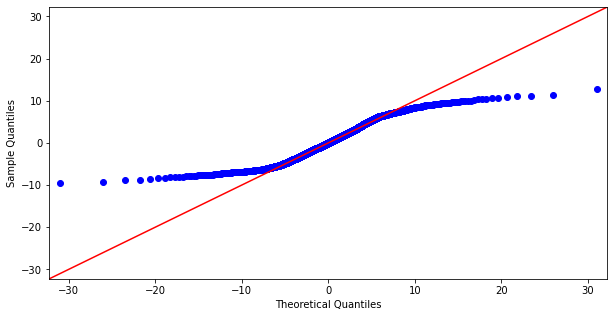

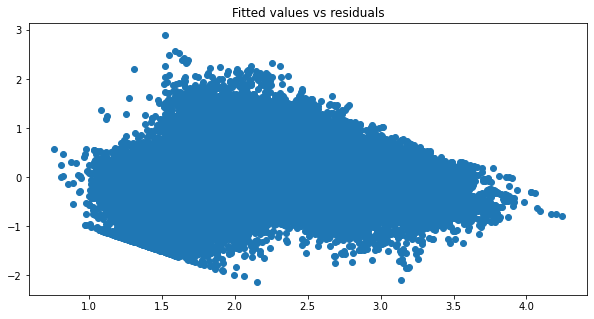

In [94]:
X = sm.add_constant(df_modeling[x_all + instrument])
y = df_modeling['pm25_log']
fit1 = sm.OLS(y, X).fit()

# add fitted y value to our dataset
df_modeling['yhat_pm25_log'] = fit1.fittedvalues.values

# resid
resids = fit1.resid
resids_and_fitted = pd.DataFrame({'resids': fit1.resid, 'fitted': fit1.fittedvalues.values})

#p-values
#fit1.pvalues

# rmse
rmse = np.mean(np.array(df_modeling['yhat_pm25_log'] - df_modeling['pm25_log']) ** 2) ** .5
print(f'RMSE: {rmse}')

# model summary
print(fit1.summary())

# qqplot
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (10,5)
fig = sm.qqplot(resids, stats.t, fit=True, line="45")
plt.show()

# resid vs fitted
plt.scatter(resids_and_fitted['fitted'], resids_and_fitted['resids'])
plt.title('Fitted values vs residuals')
plt.show()

<AxesSubplot:>

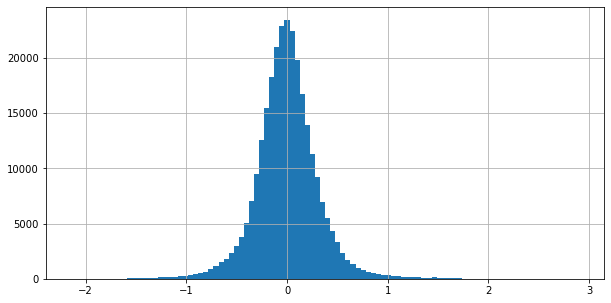

In [95]:
# histogram of the residuals
resids_and_fitted['resids'].hist(bins=100)

# Second Stage Regression

- Stage 1 of the least squares regression: $\hat{x} = z \delta$.
  - $\hat{x}$ = Predicted pm2.5 amounts ($\hat{pm2.5}$). We'll use this predicted var to predict our final Y, health outcomes. 
  - $z$ = Instrument = `avg_wind_alignment_cosine`. But this right hand side of the equation should also include all other exogenous (x) vars. 
  
- Stage 2 of the equation: $\hat{y} = \hat{x} \beta$
  - $\hat{y}$ = predicted medical outcome
  - $\hat{x}$ = predicted pm2.5 amt from the first stage. But we also should include the other exogenous vars. 

p-value: 0.07135921005646764
                            OLS Regression Results                            
Dep. Variable:        y_hematopoietic   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     12.71
Date:                Mon, 17 Oct 2022   Prob (F-statistic):          2.95e-108
Time:                        21:57:11   Log-Likelihood:             1.2903e+06
No. Observations:              277875   AIC:                        -2.580e+06
Df Residuals:                  277821   BIC:                        -2.580e+06
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

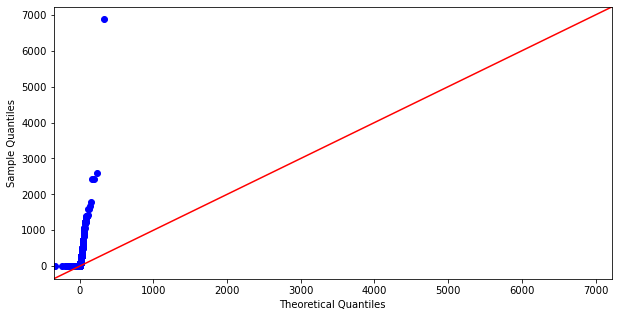

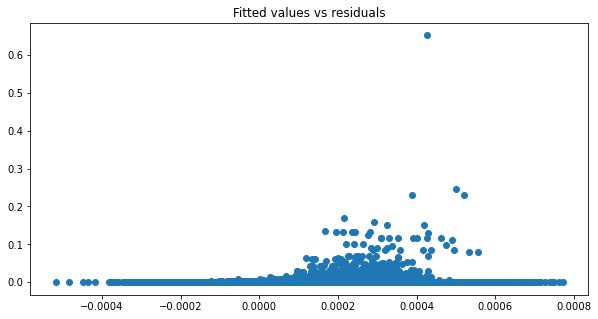

In [97]:
X = sm.add_constant(df_modeling[x_all + ['yhat_pm25_log']])
y = df_modeling['y_hematopoietic']
fit2_hema = sm.OLS(y, X).fit()

# add fitted y value to our dataset
#df_modeling['yhat_pm25'] = fit2.fittedvalues.values
# resid
resids = fit2_hema.resid
resids_and_fitted_hema = pd.DataFrame({'resids': fit2_hema.resid, 'fitted': fit2_hema.fittedvalues.values})

# p-value
print(f'p-value: {fit2_hema.pvalues.to_frame().iloc[-1][0]}')

print(fit2_hema.summary())

# qqplot
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (10,5)
fig = sm.qqplot(resids, stats.t, fit=True, line="45")
plt.show()

# resid vs fitted
plt.scatter(resids_and_fitted_hema['fitted'], resids_and_fitted_hema['resids'])
plt.title('Fitted values vs residuals')
plt.show()

                            OLS Regression Results                            
Dep. Variable:           y_vasculitis   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     10.75
Date:                Mon, 17 Oct 2022   Prob (F-statistic):           1.40e-87
Time:                        21:57:16   Log-Likelihood:             1.4163e+06
No. Observations:              277875   AIC:                        -2.833e+06
Df Residuals:                  277821   BIC:                        -2.832e+06
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

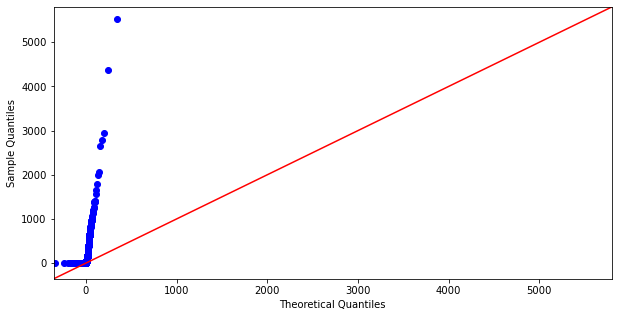

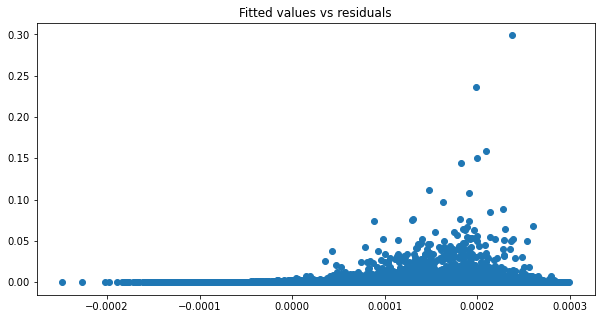

In [98]:
X = sm.add_constant(df_modeling[x_all + ['yhat_pm25_log']])
y = df_modeling['y_vasculitis']
fit2_vasc = sm.OLS(y, X).fit()

# add fitted y value to our dataset
#df_modeling['yhat_pm25'] = fit2.fittedvalues.values
# resid
resids = fit2_vasc.resid
resids_and_fitted_vasc = pd.DataFrame({'resids': fit2_vasc.resid, 'fitted': fit2_vasc.fittedvalues.values})

print(fit2_vasc.summary())

# p-value
print(f'p-value: {fit2_vasc.pvalues.to_frame().iloc[-1][0]}')

# qqplot
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (10,5)
fig = sm.qqplot(resids, stats.t, fit=True, line="45")
plt.show()

# resid vs fitted
plt.scatter(resids_and_fitted_vasc['fitted'], resids_and_fitted_vasc['resids'])
plt.title('Fitted values vs residuals')
plt.show()

                            OLS Regression Results                            
Dep. Variable:             y_diabetes   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.928
Date:                Mon, 17 Oct 2022   Prob (F-statistic):           2.85e-29
Time:                        21:57:35   Log-Likelihood:             1.0172e+06
No. Observations:              277875   AIC:                        -2.034e+06
Df Residuals:                  277821   BIC:                        -2.034e+06
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

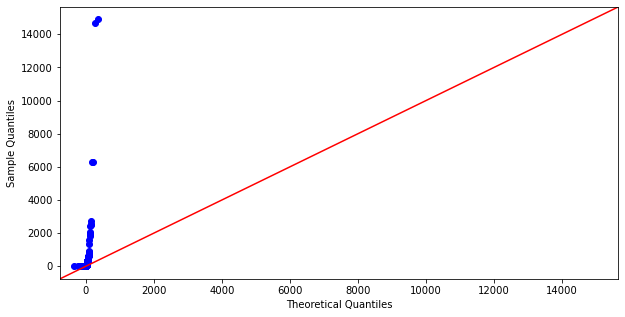

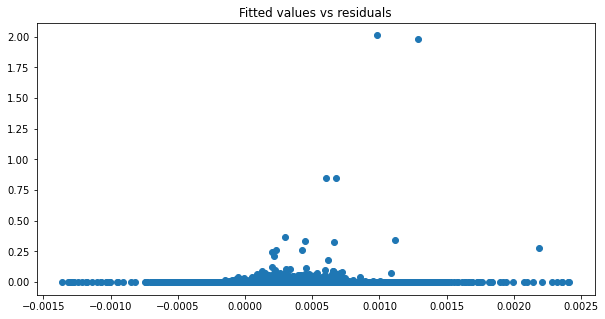

In [100]:
X = sm.add_constant(df_modeling[x_all + ['yhat_pm25_log']])
y = df_modeling['y_diabetes']
fit2_diab = sm.OLS(y, X).fit()

# add fitted y value to our dataset
#df_modeling['yhat_pm25'] = fit2.fittedvalues.values
# resid
resids = fit2_diab.resid

resids_and_fitted_diab = pd.DataFrame({'resids': fit2_diab.resid, 'fitted': fit2_diab.fittedvalues.values})

print(fit2_diab.summary())

# p-value
print(f'p-value: {fit2_diab.pvalues.to_frame().iloc[-1][0]}')

# qqplot
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (10,5)
fig = sm.qqplot(resids, stats.t, fit=True, line="45")
plt.show()

# resid vs fitted
plt.scatter(resids_and_fitted_diab['fitted'], resids_and_fitted_diab['resids'])
plt.title('Fitted values vs residuals')
plt.show()

# Verify the Exclusion Restriction
- Exclusion restriction: Our instrument (wind bearing) cannot be correlated to the residuals from the 2nd stage regression. 


              wind_bearing   hema_resids   vasc_resids   diab_resids
wind_bearing  1.000000e+00 -4.397553e-13 -4.314688e-13 -2.758489e-13
hema_resids  -4.397553e-13  1.000000e+00  2.191440e-02  9.329757e-04
vasc_resids  -4.314688e-13  2.191440e-02  1.000000e+00  1.109751e-03
diab_resids  -2.758489e-13  9.329757e-04  1.109751e-03  1.000000e+00


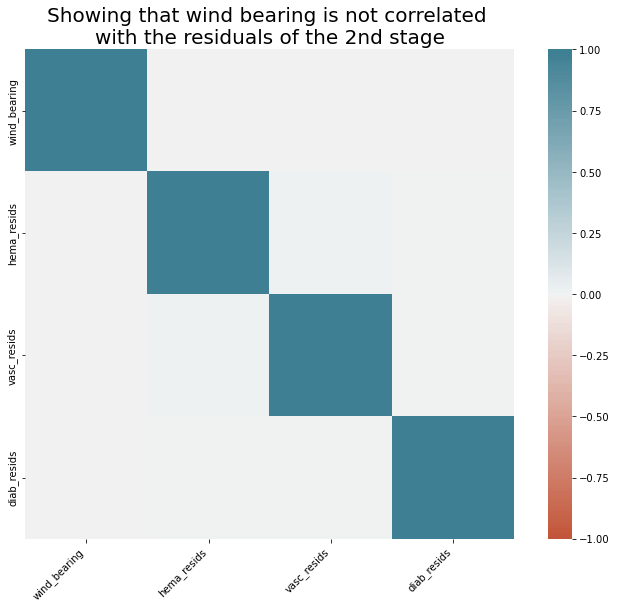

In [111]:
df_corr = pd.DataFrame({
  'wind_bearing': df_modeling['avg_wind_alignment_cosine'].values, 
  'hema_resids': resids_and_fitted_hema.resids.values,
  'vasc_resids': resids_and_fitted_vasc.resids.values, 
  'diab_resids': resids_and_fitted_diab.resids.values
}).corr()

# plot the results
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df_corr, vmin=-1, center=0, vmax=1, cmap=sns.diverging_palette(20, 220, n=200), square=True)

ax.set_xticklabels(ax.get_xticklabels(), 
    rotation=45, horizontalalignment='right')
ax.set_title("Showing that wind bearing is not correlated \nwith the residuals of the 2nd stage", fontdict = {"fontsize": 20})
print('')

print(df_corr)